In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


from sklearn import preprocessing
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import StratifiedKFold


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

2024-09-01 18:27:34.970613: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-01 18:27:35.005629: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-01 18:27:35.416029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 18:27:36.147541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 18:27:36.171496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 18:27:36.204603: I tensorflow/core/platform/cpu_feature_gu

In [10]:
# Load the entire dataset into a pandas dataframe

df = pd.read_parquet('/nobackup/amimalik/bits/dataset/dimensions/4Q/working_dataset.parquet')
model_df = pd.read_csv('/nobackup/amimalik/bits/dataset/dimensions/4Q/sorted_failures.csv')

model_df = model_df.head(5)

In [11]:
df.shape

(469625, 13)

In [12]:
def group_by_serial_number(df, count):

    # Group the instances dataframe by serial number
    grouped_instances = df.groupby('serial_number')

    # Create an empty list to store the last 150 samples for each serial number
    last_n = []

    # Iterate over each group
    for name, group in grouped_instances:
        # Get the last n (count) samples for the current serial number
        last_n_group = group.tail(count)
        # Append the last n samples to the list
        last_n.append(last_n_group)

    # Concatenate the list of dataframes into a single dataframe
    instance_last_n = pd.concat(last_n)

    # Reset the index of the dataframe
    instance_last_n.reset_index(drop=True, inplace=True)

    # Drop the date column from the dataframe
    # instance_last_n.drop(columns=['date'], inplace=True)

    # reset index
    instance_last_n.reset_index(drop=True, inplace=True)
    
    # Print the updated dataframe
    # instance_last_n.head()

    return instance_last_n

In [13]:
ddf = group_by_serial_number(df, 30)
ddf.shape

(121664, 13)

In [14]:
ddf.to_parquet("/nobackup/amimalik/bits/dataset/dimensions/4Q/working_dataset_time.parquet")

In [15]:
def get_model_data(df, model):
    model_df = df[df['model'] == model]
    model_df = model_df.drop(columns=['model'])
    model_df.drop(columns=['serial_number'], inplace=True)
    return model_df


In [16]:
def get_clean_data(df):
    test = df.isnull().sum()
    d_col = []
    for k in test.keys():
        if test[k] == df.shape[0]:
            d_col.append(k)
    df.drop(columns=d_col, inplace=True)
    # replace null by mean values
    for col in df.columns:
        df[col].fillna(df[col].mean(), inplace=True)
    # reset index
    df.reset_index(drop=True, inplace=True)
    return df

In [20]:
# Define a function that performs stratified cross-validation

def stratified_data_split(df):
    # Define the number of folds
    n_folds = 2

    # Create an instance of StratifiedKFold
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Split the data into X and y
    X = df.drop(columns=['failure'])
    y = df['failure']

    # Perform stratified cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_train = np.array(y_train).reshape(-1, 1)
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        y_test = np.array(y_test).reshape(-1, 1)
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        yield X_train, y_train, X_test, y_test

In [21]:
def model_fit(X_train, y_train, x_test, y_test, dev_model, fold_count, epochs=50, batch_size=32, learning_rate=0.001):
    validation_number = int(0.9 * X_train.shape[0])
    validation_X = X_train[validation_number:]
    validation_y = y_train[validation_number:]
    train_X = X_train[:validation_number]
    train_y = y_train[:validation_number]


    # Define the model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.25))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Fit the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(validation_X, validation_y), verbose=0)

    # summarize performance of the model
    scores = model.evaluate(train_X, train_y, verbose=0)
    # print(model.metrics_names)
    # print("model loss: %.2f%%" % (scores*100))

    # Use the trained model to predict on the test_X dataset
    predictions = model.predict(test_X)

    # Print the predictions
    # print(predictions)

    # Convert the predictions to binary values (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(test_y, binary_predictions)
    precision = precision_score(test_y, binary_predictions)
    recall = recall_score(test_y, binary_predictions)
    f1 = f1_score(test_y, binary_predictions)
    roc_auc = roc_auc_score(test_y, binary_predictions)

    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("ROC AUC score:", roc_auc)


    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('model accuracy for model: ' + dev_model + ' fold: ' + str(fold_count))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

    return model

Model:  ST12000NM0008
(8559, 1, 9) (8559, 1) (8559, 1, 9) (8559, 1)
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9652996845425867
Precision: 1.0
Recall: 0.003355704697986577
F1-score: 0.006688963210702341
ROC AUC score: 0.5016778523489933


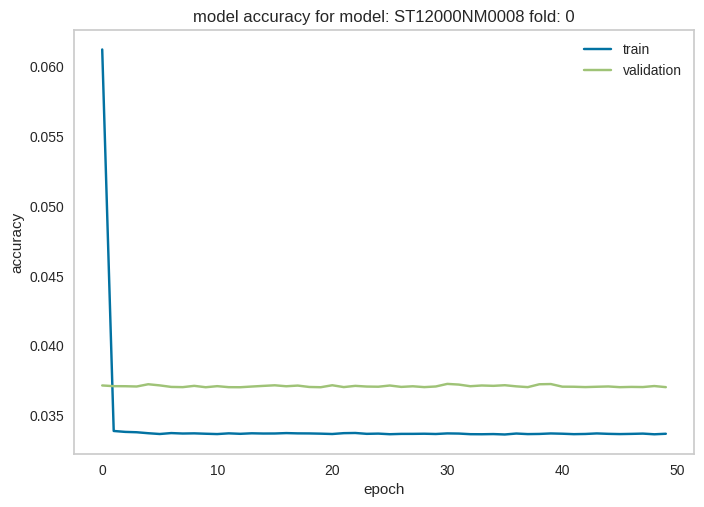

(8559, 1, 9) (8559, 1) (8559, 1, 9) (8559, 1)
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9650660123846244
Precision: 0.5
Recall: 0.0033444816053511705
F1-score: 0.006644518272425249
ROC AUC score: 0.5016117081150243


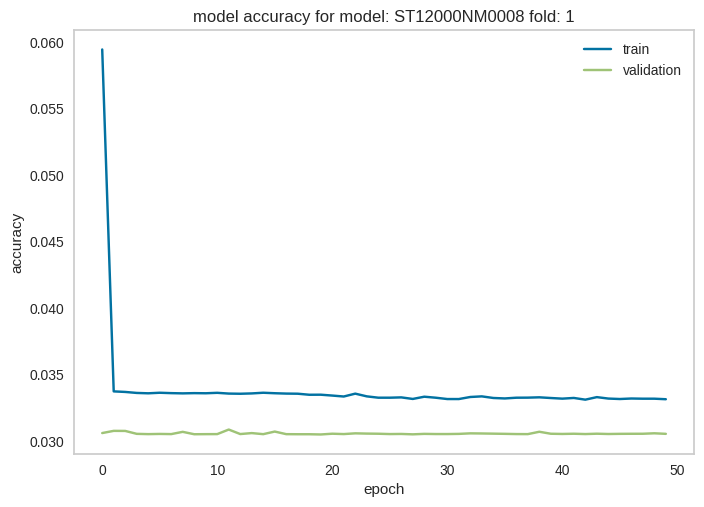

Model:  ST8000NM0055
(6510, 1, 10) (6510, 1) (6510, 1, 10) (6510, 1)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9623655913978495
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


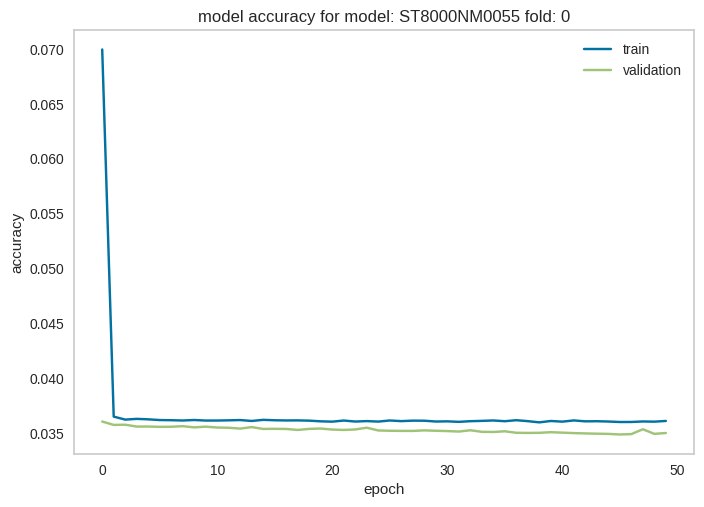

(6510, 1, 10) (6510, 1) (6510, 1, 10) (6510, 1)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9623655913978495
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


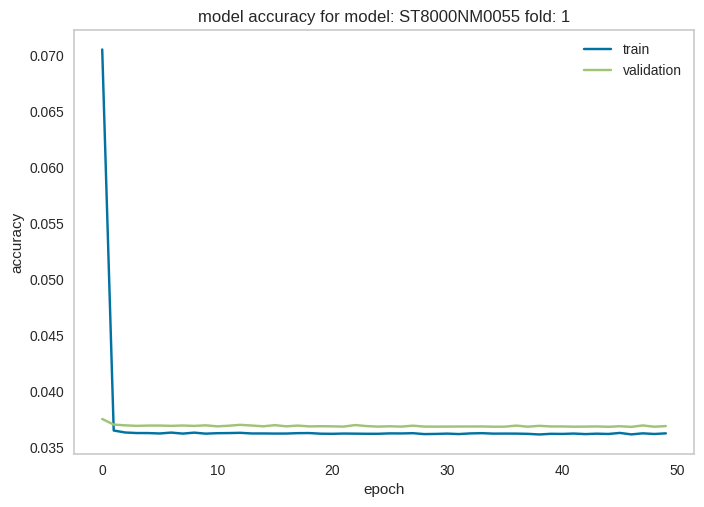

Model:  ST4000DM000
(6305, 1, 10) (6305, 1) (6305, 1, 10) (6305, 1)
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9641554321966693
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


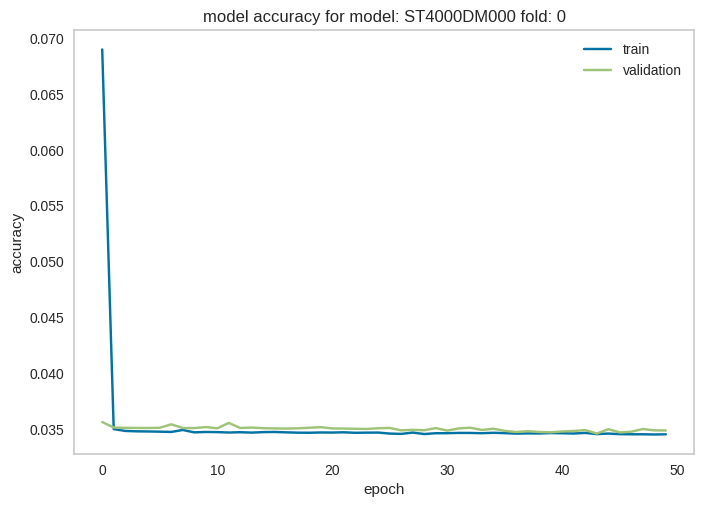

(6305, 1, 10) (6305, 1) (6305, 1, 10) (6305, 1)
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9638382236320381
Precision: 0.4
Recall: 0.00881057268722467
F1-score: 0.017241379310344827
ROC AUC score: 0.5041584946358137


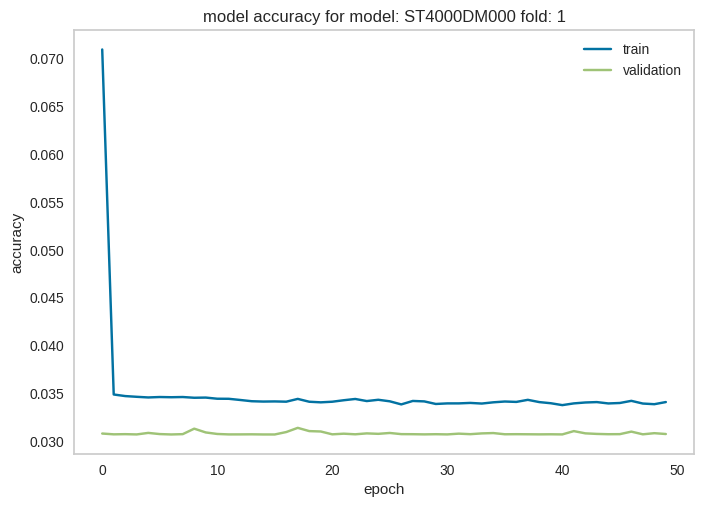

Model:  TOSHIBA MG07ACA14TA
(5875, 1, 6) (5875, 1) (5875, 1, 6) (5875, 1)
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9644255319148937
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


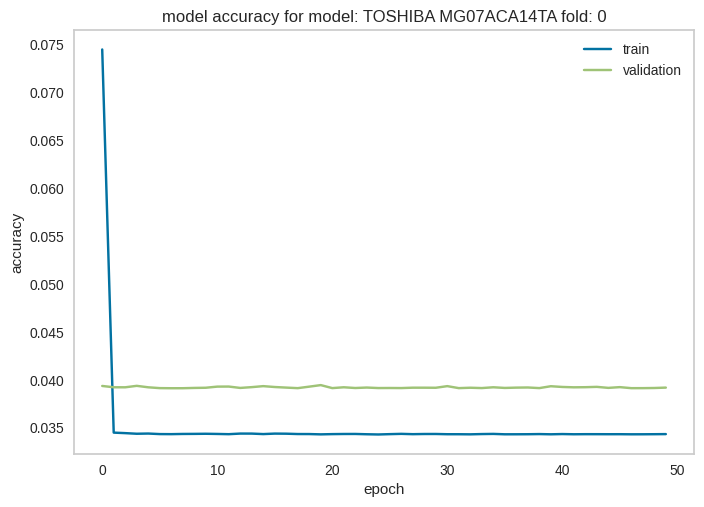

(5875, 1, 6) (5875, 1) (5875, 1, 6) (5875, 1)
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9644255319148937
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


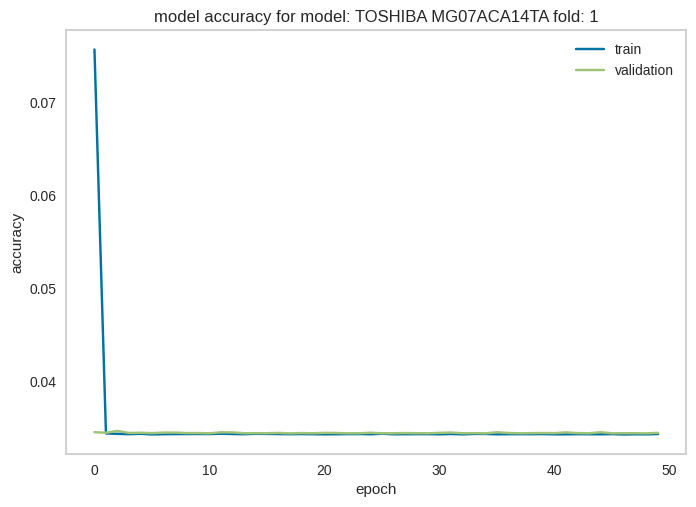

Model:  HGST HUH721212ALN604
(5207, 1, 5) (5207, 1) (5208, 1, 5) (5208, 1)
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9612135176651305
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


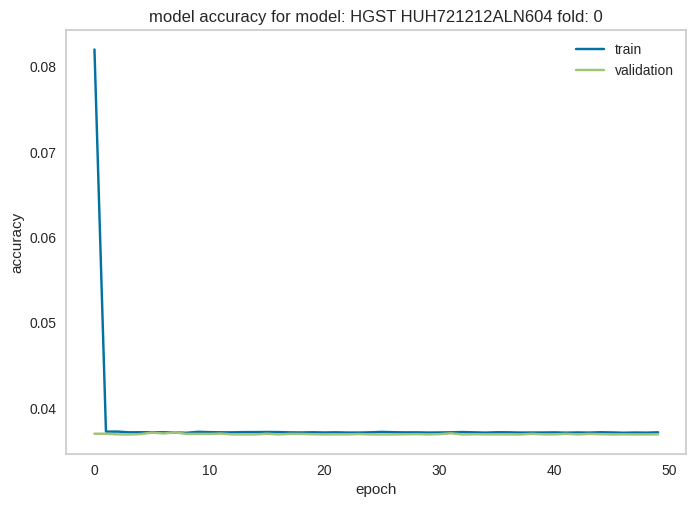

(5208, 1, 5) (5208, 1) (5207, 1, 5) (5207, 1)
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.9613981179181871
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


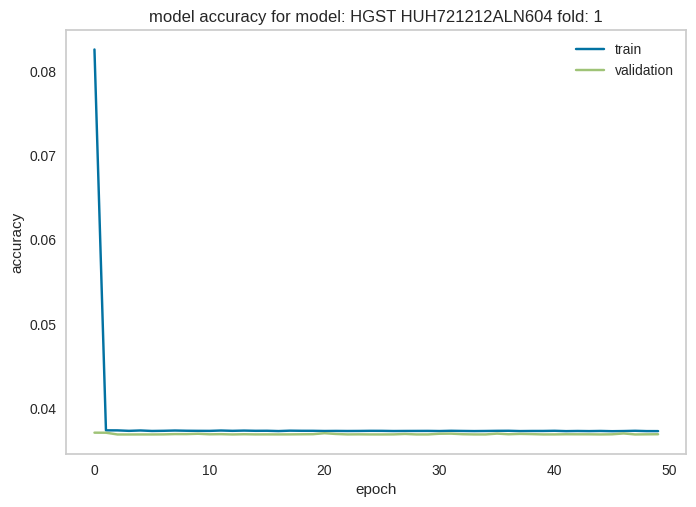

In [22]:
for dev_models in model_df['model']:
    model_data = get_model_data(ddf, dev_models)
    model_data = get_clean_data(model_data)
    fold_count = 0
    print ("Model: ", dev_models)
    for train_X, train_y, test_X, test_y in stratified_data_split(model_data):
        #print(train_X.shape, train_y.shape, test_X.shape)
        #print(train_X.shape[0], train_X.shape[1])
        #print(np.isnan(train_X).sum())
        #print(np.isnan(train_y).sum())

        #scaler = StandardScaler()
        #X_train_scaled = scaler.fit_transform(train_X)
        #X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

        #print(X_train_scaled.shape, train_y.shape, test_X.shape)

        model_fit(train_X, train_y, test_X, test_y, epochs=50, batch_size=32, learning_rate=0.001, dev_model=dev_models, fold_count=fold_count)
        fold_count += 1